# 3.3 LangGraph에서 도구(tool) 활용 방법

- 도구(tool)를 활용한 에이전트 개발 방법을 알아봅니다
- workflow를 직접 선언하지 않고, 사용가능한 도구들을 전달하면, 에이전트가 적합한 도구를 판단해서 사용합니다
    - 이번 회차에서는 `ToolNode`를 통해 도구를 활용하는 방법을 알아봅니다

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-2024-11-20',
    api_version='2024-08-01-preview',   
)

small_llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-mini-2024-07-18',
    api_version='2024-08-01-preview',
)

In [4]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

- LangGraph는 `ToolNode`를 통해 도구를 활용합니다
- `ToolNode`의 `invoke()`결과는 도구의 `invoke()` 결과와 유사합니다
    - 도구는 도구의 실행 결과를 리턴하고, `ToolNode`는 도구의 실행 결과를 포함한 `ToolMessage`를 리턴합니다

In [5]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [6]:
multiply.invoke({'a': 3, 'b': 5})

15

In [7]:
ai_message = llm_with_tools.invoke('What is 3 plus 5?')

In [8]:
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_REgIa1XSjrRLaUgnS0d6mKsE', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 84, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id

- `ToolNode`를 `invoke()`하려면 `tool_calls` 속성을 포함한 `AIMessage`를 전달해야 합니다

In [9]:
tool_node.invoke({'messages': [ai_message]})

{'messages': [ToolMessage(content='8', name='add', tool_call_id='call_REgIa1XSjrRLaUgnS0d6mKsE')]}

In [10]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [11]:
def agent(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

In [12]:
from langgraph.graph import END

def should_continue(state: MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    if last_ai_message.tool_calls:
        return 'tools'
    return END

- `node`를 추가하고 `edge`로 연결합니다

In [13]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

In [15]:
graph= graph_builder.compile()

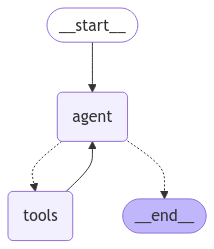

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5를 더하고 거기에 8을 곱하면?
================================== Ai Message ==================================
Tool Calls:
  add (call_xetei0iBWnHNcX6SMC2rEQxC)
 Call ID: call_xetei0iBWnHNcX6SMC2rEQxC
  Args:
    a: 3
    b: 5
  multiply (call_2CjyyFuLVKl8ddfHQOt5Po9M)
 Call ID: call_2CjyyFuLVKl8ddfHQOt5Po9M
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiply

64
================================== Ai Message ==================================
Tool Calls:
  multiply (call_TP5AABD5iKpKsnfwRXGCrVF6)
 Call ID: call_TP5AABD5iKpKsnfwRXGCrVF6
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiply

64
================================== Ai Message ==================================

3에 5를 더하면 8이 되고, 그 결과에 8을 곱하면 64가 됩니다. 따라서 최종 결과는 64입니다.
